In [22]:
!pip3 install Pillow --quiet

import time
import torch
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm, trange
from PIL import Image

# Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import ipywidgets as widgets  # Interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

# Helper Functions
from scipy.signal import correlate2d
import zipfile, gzip, shutil, tarfile


def download_data(fname, folder, url, tar):
  """
  Data downloading from OSF.

  Args:
    fname : str
      The name of the archive
    folder : str
      The name of the destination folder
    url : str
      The download url
    tar : boolean
      `tar=True` the archive is `fname`.tar.gz, `tar=False` is `fname`.zip

  Returns:
    Nothing.
  """

  if not os.path.exists(folder):
    print(f'\nDownloading {folder} dataset...')
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
      fh.write(r.content)
    print(f'\nDownloading {folder} completed.')

    print('\nExtracting the files...\n')
    if not tar:
      with zipfile.ZipFile(fname, 'r') as fz:
        fz.extractall()
    else:
      with tarfile.open(fname) as ft:
        ft.extractall()
    # Remove the archive
    os.remove(fname)

    # Extract all .gz files
    foldername = folder + '/raw/'
    for filename in os.listdir(foldername):
      # Remove the extension
      fname = filename.replace('.gz', '')
      # Gunzip all files
      with gzip.open(foldername + filename, 'rb') as f_in:
        with open(foldername + fname, 'wb') as f_out:
          shutil.copyfileobj(f_in, f_out)
          os.remove(foldername+filename)
  else:
    print(f'{folder} dataset has already been downloaded.\n')


def check_shape_function(func, image_shape, kernel_shape):
  """
  Helper function to check shape implementation

  Args:
    func: f.__name__
      Function name
    image_shape: tuple
      Image shape
    kernel_shape: tuple
      Kernel shape

  Returns:
    Nothing
  """
  correct_shape = correlate2d(np.random.rand(*image_shape), np.random.rand(*kernel_shape), "valid").shape
  user_shape = func(image_shape, kernel_shape)
  if correct_shape != user_shape:
    print(f"❌ Your calculated output shape is not correct.")
  else:
    print(f"✅ Output for image_shape: {image_shape} and kernel_shape: {kernel_shape}, output_shape: {user_shape}, is correct.")


def check_conv_function(func, image, kernel):
  """
  Helper function to check conv_function

  Args:
    func: f.__name__
      Function name
    image: np.ndarray
      Image matrix
    kernel_shape: np.ndarray
      Kernel matrix

  Returns:
    Nothing
  """
  solution_user = func(image, kernel)
  solution_scipy = correlate2d(image, kernel, "valid")
  result_right = (solution_user == solution_scipy).all()
  if result_right:
    print("✅ The function calculated the convolution correctly.")
  else:
    print("❌ The function did not produce the right output.")
    print("For the input matrix:")
    print(image)
    print("and the kernel:")
    print(kernel)
    print("the function returned:")
    print(solution_user)
    print("the correct output would be:")
    print(solution_scipy)


def check_pooling_net(net, device='cpu'):
  """
  Helper function to check pooling output

  Args:
    net: nn.module
      Net instance
    device: string
      GPU/CUDA if available, CPU otherwise.

  Returns:
    Nothing
  """
  x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(device)
  output_x = net(x_img)
  output_x = output_x.squeeze(dim=0).detach().cpu().numpy()

  right_output = [
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000],
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000],
      [9.309552, 1.6216984, 0.000000, 0.000000, 0.000000, 0.000000, 2.2708383,
      2.6654134, 1.2271233, 0.000000, 0.000000, 0.000000],
      [12.873457, 13.318945, 9.46229, 4.663746, 0.000000, 0.000000, 1.8889914,
      0.31068993, 0.000000, 0.000000, 0.000000, 0.000000],
      [0.000000, 8.354934, 10.378724, 16.882853, 18.499334, 4.8546696, 0.000000,
      0.000000, 0.000000, 6.29296, 5.096506, 0.000000],
      [0.000000, 0.000000, 0.31068993, 5.7074604, 9.984148, 4.12916, 8.10037,
      7.667609, 0.000000, 0.000000, 1.2780352, 0.000000],
      [0.000000, 2.436305, 3.9764223, 0.000000, 0.000000, 0.000000, 12.98801,
      17.1756, 17.531992, 11.664275, 1.5453291, 0.000000],
      [4.2691708, 2.3217516, 0.000000, 0.000000, 1.3798618, 0.05612564, 0.000000,
      0.000000, 11.218788, 16.360992, 13.980816, 8.354935],
      [1.8126211, 0.000000, 0.000000, 2.9199777, 3.9382377, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 6.076582, 10.035061],
      [0.000000, 0.92164516, 4.434638, 0.7816348, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.83254766],
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000],
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000]
  ]

  right_shape = (3, 12, 12)

  if output_x.shape != right_shape:
    print(f"❌ Your output does not have the right dimensions. Your output is {output_x.shape} the expected output is {right_shape}")
  elif (output_x[0] != right_output).all():
    print("❌ Your output is not right.")
  else:
    print("✅ Your network produced the correct output.")


# Just returns accuracy on test data
def test(model, device, data_loader):
  """
  Test function

  Args:
    net: nn.module
      Net instance
    device: string
      GPU/CUDA if available, CPU otherwise.
    data_loader: torch.loader
      Test loader

  Returns:
    acc: float
      Test accuracy
  """
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return f"{acc}%"

# Plotting functions
def display_image_from_greyscale_array(matrix, title):
  """
  Display image from greyscale array

  Args:
    matrix: np.ndarray
      Image
    title: string
      Title of plot

  Returns:
    Nothing
  """
  _matrix = matrix.astype(np.uint8)
  _img = Image.fromarray(_matrix, 'L')
  plt.figure(figsize=(3, 3))
  plt.imshow(_img, cmap='gray', vmin=0, vmax=255) # Using 220 instead of 255 so the examples show up better
  plt.title(title)
  plt.axis('off')


def make_plots(original, actual_convolution, solution):
  """
  Function to build original image/obtained solution and actual convolution

  Args:
    original: np.ndarray
      Image
    actual_convolution: np.ndarray
      Expected convolution output
    solution: np.ndarray
      Obtained convolution output

  Returns:
    Nothing
  """
  display_image_from_greyscale_array(original, "Original Image")
  display_image_from_greyscale_array(actual_convolution, "Convolution result")
  display_image_from_greyscale_array(solution, "Your solution")


def plot_loss_accuracy(train_loss, train_acc,
                       validation_loss, validation_acc):
  """
  Code to plot loss and accuracy

  Args:
    train_loss: list
      Log of training loss
    validation_loss: list
      Log of validation loss
    train_acc: list
      Log of training accuracy
    validation_acc: list
      Log of validation accuracy

  Returns:
    Nothing
  """
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)

  # Set Random Seed
  # @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

# Set Device
def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Random seed 2021 has been set.


# Introduction to CNNs

Convolutional Neural Networks (CNNs) operate on images (for the most part).

Share parameters over space (?)

Recurrent Neural Networks (RNNs) operate on sequences of data, process data over time.  Paramater sharing over time.  For time series etc..

Images have a huge amount of weight (parameters) in a conventional neural network.. the first layer would be getting for example 256*256 * neurons in linayer, could easily surpass a million.

Modern CNNs can have dozens of layers. So CNNs change the architecture to reduce the number of parameters.

Intuitively, parameter sharing makes sense in an image because you could have for example a picture of flowers and it features a recurrence of a type of flower in multiple places.

**Weight-sharing** is based on the idea that some sets of weights can be used at multiple points in a network. We will focus primarily on CNNs today, where the weight-sharing is across the 2D space of an image. This weight-sharing technique (across space) can reduce the number of parameters and increase a network’s ability to generalize. For completeness, a similar approach is the Recurrent Neural Networks (RNNs), which share parameters across time, but we will not dive into this in this tutorial.

**Padding** puts a border of empty pixels around an image and allows **filters** to consider stuff at the edges that might be cutoff.  The **stride** is how many pixels you move the filter at a time.

At its core, convolution is just repeatedly multiplying a matrix, known as a kernel or filter, with some other, larger matrix (in our case the pixels of an image). Consider the below image and kernel:

$$
\begin{aligned}
\text { Image } & =\left[\begin{array}{ccc}
0 & 200 & 200 \\
0 & 0 & 200 \\
0 & 0 & 0
\end{array}\right] \\
\text { Kernel } & =\left[\begin{array}{cc}
\frac{1}{4} & \frac{1}{4} \\
\frac{1}{4} & \frac{1}{4}
\end{array}\right]
\end{aligned}
$$

✅ Your solution is correct!



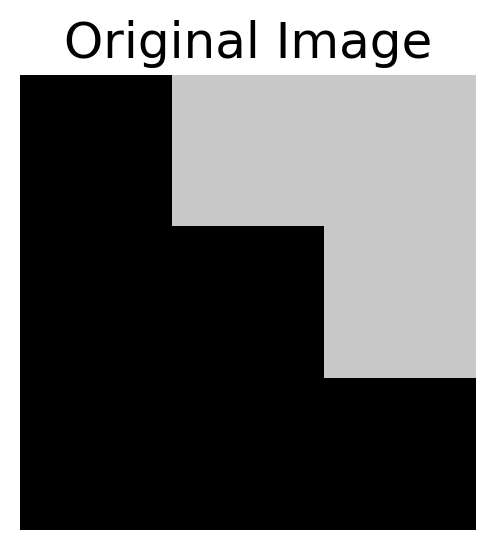

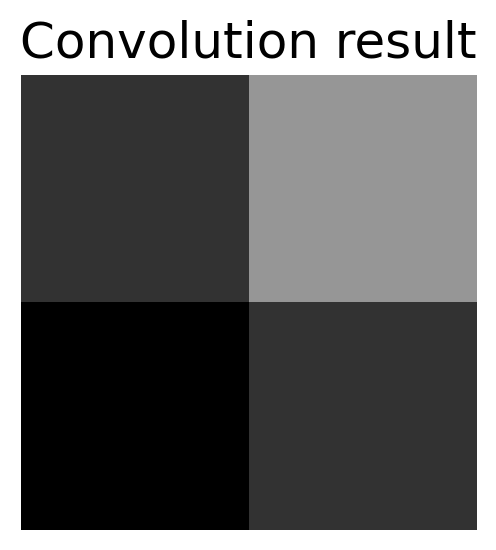

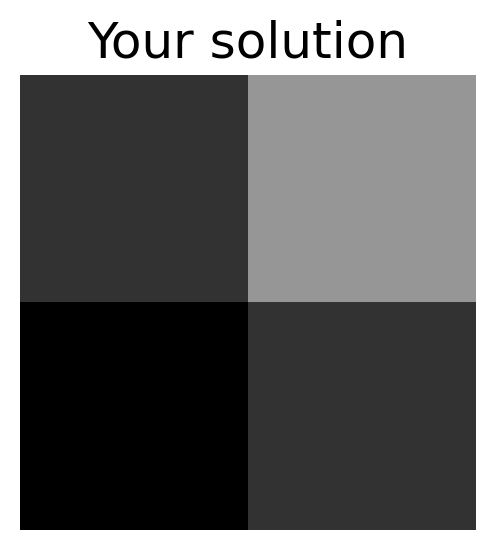

In [23]:
def conv_check():
  """
  Demonstration of convolution operation

  Args:
    None

  Returns:
    original: np.ndarray
      Image
    actual_convolution: np.ndarray
      Expected convolution output
    solution: np.ndarray
      Obtained convolution output
    kernel: np.ndarray
      Kernel
  """

  # Write the solution array and call the function to verify it!
  solution = np.array([
                    [50, 150],
                    [0, 50]
  ])

  original = np.array([
                       [0, 200, 200],
                       [0, 0, 200],
                       [0, 0, 0]
                       ])

  kernel = np.array([
                     [0.25, 0.25],
                     [0.25, 0.25]
                     ])

  actual_convolution = scipy.signal.correlate2d(original, kernel, mode="valid")

  if (solution == actual_convolution).all():
    print("✅ Your solution is correct!\n")
  else:
    print("❌ Your solution is incorrect.\n")

  return original, kernel, actual_convolution, solution



## Uncomment to test your solution!
original, kernel, actual_convolution, solution = conv_check()
make_plots(original, actual_convolution, solution)

In [24]:
def calculate_output_shape(image_shape, kernel_shape):
  """
  Helper function to calculate output shape

  Args:
    image_shape: tuple
      Image shape
    kernel_shape: tuple
      Kernel shape

  Returns:
    output_height: int
      Output Height
    output_width: int
      Output Width
  """
  image_height, image_width = image_shape
  kernel_height, kernel_width = kernel_shape

  output_height = image_height - kernel_height + 1
  output_width = image_width - kernel_width + 1
  return output_height, output_width



# Here we check if your function works correcly by applying it to different image
# and kernel shapes
check_shape_function(calculate_output_shape, image_shape=(3, 3), kernel_shape=(2, 2))
check_shape_function(calculate_output_shape, image_shape=(3, 4), kernel_shape=(2, 3))
check_shape_function(calculate_output_shape, image_shape=(5, 5), kernel_shape=(5, 5))
check_shape_function(calculate_output_shape, image_shape=(10, 20), kernel_shape=(3, 2))
check_shape_function(calculate_output_shape, image_shape=(100, 200), kernel_shape=(40, 30))

✅ Output for image_shape: (3, 3) and kernel_shape: (2, 2), output_shape: (2, 2), is correct.
✅ Output for image_shape: (3, 4) and kernel_shape: (2, 3), output_shape: (2, 2), is correct.
✅ Output for image_shape: (5, 5) and kernel_shape: (5, 5), output_shape: (1, 1), is correct.
✅ Output for image_shape: (10, 20) and kernel_shape: (3, 2), output_shape: (8, 19), is correct.
✅ Output for image_shape: (100, 200) and kernel_shape: (40, 30), output_shape: (61, 171), is correct.


In [25]:
def convolution2d(image, kernel):
  """
  Convolves a 2D image matrix with a kernel matrix.

  Args:
    image: np.ndarray
      Image
    kernel: np.ndarray
      Kernel

  Returns:
    output: np.ndarray
      Output of convolution
  """

  # Get the height/width of the image, kernel, and output
  im_h, im_w = image.shape
  ker_h, ker_w = kernel.shape
  out_h = im_h - ker_h + 1
  out_w = im_w - ker_w + 1

  # Create an empty matrix in which to store the output
  output = np.zeros((out_h, out_w))

  # Iterate over the different positions at which to apply the kernel,
  # storing the results in the output matrix
  for out_row in range(out_h):
    for out_col in range(out_w):
      # Overlay the kernel on part of the image
      # (multiply each element of the kernel with some element of the image, then sum)
      # to determine the output of the matrix at a point
      current_product = 0
      for i in range(ker_h):
        for j in range(ker_w):
          current_product += kernel[i][j] * image[out_row + i][out_col + j]

      output[out_row, out_col] = current_product

  return output



## Tests
# First, we test the parameters we used before in the manual-calculation example
image = np.array([[0, 200, 200], [0, 0, 200], [0, 0, 0]])
kernel = np.array([[0.25, 0.25], [0.25, 0.25]])
check_conv_function(convolution2d, image, kernel)

# Next, we test with a different input and kernel (the numbers 1-9 and 1-4)
image = np.arange(9).reshape(3, 3)
kernel = np.arange(4).reshape(2, 2)
check_conv_function(convolution2d, image, kernel)

✅ The function calculated the convolution correctly.
✅ The function calculated the convolution correctly.


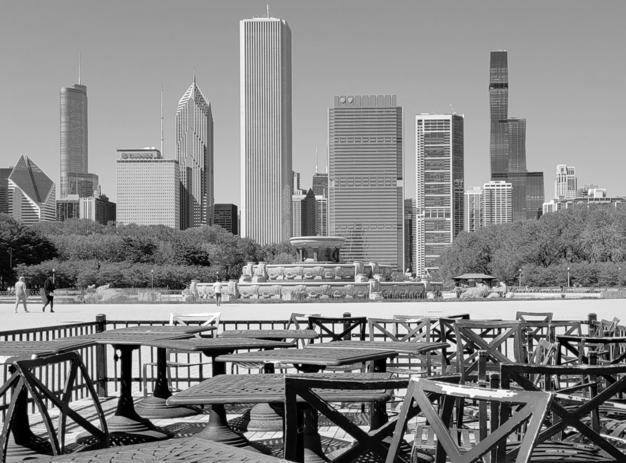

0

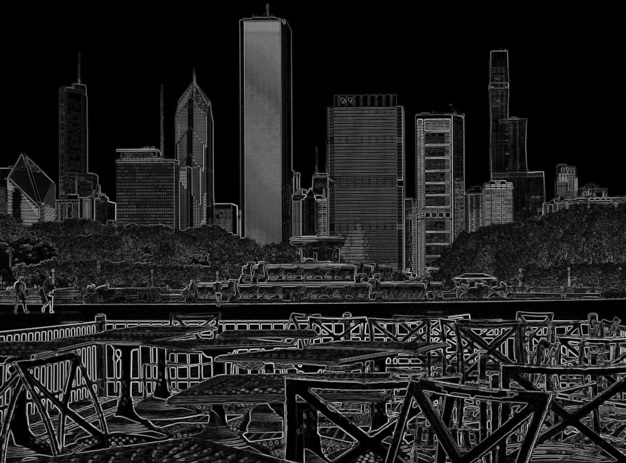

0

In [26]:
import requests, os

if not os.path.exists('images/'):
  os.mkdir('images/')

url = "https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D2_ConvnetsAndDlThinking/static/chicago_skyline_shrunk_v2.bmp"
r = requests.get(url, allow_redirects=True)
with open("images/chicago_skyline_shrunk_v2.bmp", 'wb') as fd:
  fd.write(r.content)

# Visualize the output of your function
from IPython.display import display as IPydisplay

with open("images/chicago_skyline_shrunk_v2.bmp", 'rb') as skyline_image_file:
  img_skyline_orig = Image.open(skyline_image_file)
  img_skyline_mat = np.asarray(img_skyline_orig)
  kernel_ver = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  kernel_hor = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]).T
  img_processed_mat_ver = convolution2d(img_skyline_mat, kernel_ver)
  img_processed_mat_hor = convolution2d(img_skyline_mat, kernel_hor)
  img_processed_mat = np.sqrt(np.multiply(img_processed_mat_ver,
                                          img_processed_mat_ver) + \
                              np.multiply(img_processed_mat_hor,
                                          img_processed_mat_hor))

  img_processed_mat *= 255.0/img_processed_mat.max()
  img_processed_mat = img_processed_mat.astype(np.uint8)
  img_processed = Image.fromarray(img_processed_mat, 'L')
  width, height = img_skyline_orig.size
  scale = 0.6
  IPydisplay(img_skyline_orig.resize((int(width*scale), int(height*scale))),
             Image.NEAREST)
  IPydisplay(img_processed.resize((int(width*scale), int(height*scale))),
             Image.NEAREST)


In [27]:
from IPython.display import HTML

id_html = 2.2
url = f'https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D2_ConvnetsAndDlThinking/static/interactive_demo{id_html}.html'
run_demo = True # @param {type:"boolean"}
if run_demo:
  display(HTML(url))

In [28]:
# @title Download EMNIST dataset

# webpage: https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
fname = 'EMNIST.zip'
folder = 'EMNIST'
url = "https://osf.io/xwfaj/download"
download_data(fname, folder, url, tar=False)

EMNIST dataset has already been downloaded.



In [29]:
# @title Dataset/DataLoader Functions *(Run me!)*

def get_Xvs0_dataset(normalize=False, download=False):
  """
  Load Dataset

  Args:
    normalize: boolean
      If true, normalise dataloader
    download: boolean
      If true, download dataset

  Returns:
    emnist_train: torch.loader
      Training Data
    emnist_test: torch.loader
      Test Data
  """
  if normalize:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
  else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        ])

  emnist_train = datasets.EMNIST(root='.',
                                 split='letters',
                                 download=download,
                                 train=True,
                                 transform=transform)
  emnist_test = datasets.EMNIST(root='.',
                                split='letters',
                                download=download,
                                train=False,
                                transform=transform)

  # Only want O (15) and X (24) labels
  train_idx = (emnist_train.targets == 15) | (emnist_train.targets == 24)
  emnist_train.targets = emnist_train.targets[train_idx]
  emnist_train.data = emnist_train.data[train_idx]

  # Convert Xs predictions to 1, Os predictions to 0
  emnist_train.targets = (emnist_train.targets == 24).type(torch.int64)

  test_idx = (emnist_test.targets == 15) | (emnist_test.targets == 24)
  emnist_test.targets = emnist_test.targets[test_idx]
  emnist_test.data = emnist_test.data[test_idx]

  # Convert Xs predictions to 1, Os predictions to 0
  emnist_test.targets = (emnist_test.targets == 24).type(torch.int64)

  return emnist_train, emnist_test


def get_data_loaders(train_dataset, test_dataset,
                     batch_size=32, seed=0):
  """
  Helper function to fetch dataloaders

  Args:
    train_dataset: torch.tensor
      Training data
    test_dataset: torch.tensor
      Test data
    batch_size: int
      Batch Size
    seed: int
      Set seed for reproducibility

  Returns:
    emnist_train: torch.loader
      Training Data
    emnist_test: torch.loader
      Test Data
  """
  g_seed = torch.Generator()
  g_seed.manual_seed(seed)

  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2,
                            worker_init_fn=seed_worker,
                            generator=g_seed)
  test_loader = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=True,
                           num_workers=2,
                           worker_init_fn=seed_worker,
                           generator=g_seed)

  return train_loader, test_loader

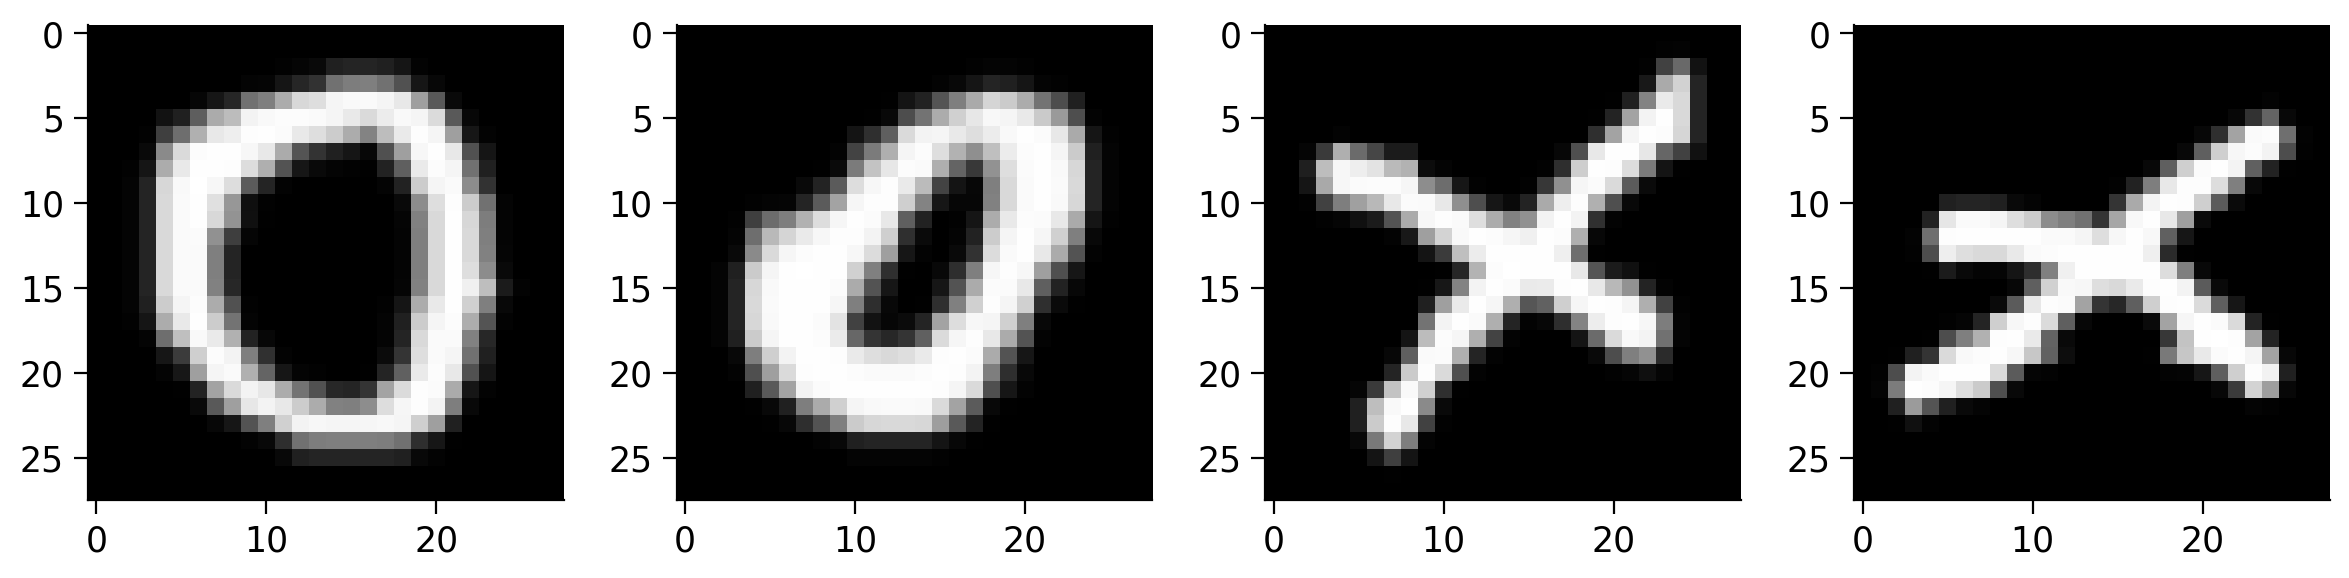

In [30]:
emnist_train, emnist_test = get_Xvs0_dataset(normalize=False, download=False)
train_loader, test_loader = get_data_loaders(emnist_train, emnist_test,
                                             seed=SEED)

# Index of an image in the dataset that corresponds to an X and O
x_img_idx = 4
o_img_idx = 15

# Let’s view a couple samples from the dataset.

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))
ax1.imshow(emnist_train[0][0].reshape(28, 28), cmap='gray')
ax2.imshow(emnist_train[10][0].reshape(28, 28), cmap='gray')
ax3.imshow(emnist_train[4][0].reshape(28, 28), cmap='gray')
ax4.imshow(emnist_train[6][0].reshape(28, 28), cmap='gray')
plt.show()

In [31]:
# @markdown *Run this cell to enable the widget!*

from IPython.display import HTML

id_html = 3
url = f'https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D2_ConvnetsAndDlThinking/static/interactive_demo{id_html}.html'
run_demo = True # @param {type:"boolean"}
if run_demo:
  display(HTML(url))

In [ ]:
class Net2(nn.Module):
  """
  Neural Network instance
  """

  def __init__(self, padding=0):
    """
    Initialize parameters of Net2

    Args:
      padding: int or tuple, optional
        Zero-padding added to both sides of the input. Default: 0

    Returns:
      Nothing
    """
    super(Net2, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                           padding=padding)

    # First kernel - leading diagonal
    kernel_1 = torch.Tensor([[[1., 1., -1., -1., -1.],
                              [1., 1., 1., -1., -1.],
                              [-1., 1., 1., 1., -1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., -1., -1., 1., 1.]]])

    # Second kernel - other diagonal
    kernel_2 = torch.Tensor([[[-1., -1., -1., 1., 1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., -1., -1.],
                              [1., 1., -1., -1., -1.]]])

    # tThird kernel - checkerboard pattern
    kernel_3 = torch.Tensor([[[1., 1., -1., 1., 1.],
                              [1., 1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., 1., 1.],
                              [1., 1., -1., 1., 1.]]])


    # Stack all kernels in one tensor with (3, 1, 5, 5) dimensions
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

    self.conv1.weight = torch.nn.Parameter(multiple_kernels)

    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))

  def forward(self, x):
    """
    Forward Pass of Net2

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution output
    """
    x = self.conv1(x)
    return x

## Pooling

Whereas filters give us global invariance, [pooling](https://youtu.be/XOss-NUlpo0) gives us local invariance..  so if something is placed somewhat nearby spatially pooling could could treat it similarly.  Like if the wind were to blow and move the positions of the flowers in an image somewhat.

In **max-pooling** you look at each patch (could be like a 2x2 patch) and take the max value for that patch as an entry in the next matrix.  Max pooling not only introduces no additional paramters, it actually effectively reduces the number of parameters by shrinking the size of the matrix passed on.

As opposed to max pooling we could also take the average.

Like convolutional layers, pooling layers have fixed-shape windows (pooling windows) that are systematically applied to the input. As with filters, we can change the shape of the window and the size of the stride.  Pooling performs a kind of information compression that provides summary statistics for a neighborhood of the input.

Pooling gives our network translational invariance by providing a summary of the values in each pooling window. Thus, a small change in the features of the underlying image won’t make a huge difference to the output.



In [32]:
from IPython.display import HTML

id_html = 3.3
url = f'https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D2_ConvnetsAndDlThinking/static/interactive_demo{id_html}.html'
run_demo = True # @param {type:"boolean"}
if run_demo:
  display(HTML(url))

Going from matrix output to a vector input requires a special step called flattening.

Typically we'll have fully connected (linear) layers at the end, preceding the final prediction.

Common structure is Input -> Convolution -> Pooling -> Convolution -> Pooling -> Fully Connected -> Fully connected -> Prediction.